In [ ]:
import pandas as pd
import numpy as np
import os

import IPython
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta, date

#show all columns and rows
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

In [ ]:
#!pip install optuna
import optuna

from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.samplers import TPESampler

In [ ]:
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb
import tensorflow as tf
tf.random.set_seed(2021)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Conv1D, MaxPool1D

In [ ]:
BATCH_SIZE = 32
MAX_EPOCHS = 10
patience = 2
zakres = 'full'   #'full','meteo','onlyPM'

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kBqs18UlSE_jeOPxJgiOgpdZLJ0GXJYC' -O weather_pm25_2015-202103.csv

In [ ]:
#wczytanie danych, dodanie zmiennych czasowych, uzupełnienie braków
df = pd.read_csv('weather_pm25_2015-202103.csv',parse_dates=['date'], index_col='date')

#dodanie zmiennych okresowych
df['month'] = df.index.month
df['year'] = df.index.year
df['hour'] = df.index.hour
df['day_of_week'] = df.index.map(lambda x: x.isocalendar()[2])
df['no_of_week'] = df.index.map(lambda x: x.isocalendar()[1])
df['year_month'] = df.apply(lambda x: datetime(x.year, x.month, 1),axis=1)


#uzupełnienie braków danych
df['PM25_nie'].interpolate(inplace=True)
df['PM25_wok'].interpolate(inplace=True)

#standaryzacja
df['PM25_wok'] = df['PM25_wok']/200
df['precipitation'] = df['precipitation'] / 10
df['pressure'] = (df['pressure'] - 950) / (1050 - 950)
df['temperature'] = (df['temperature'] +30) / (40+30)
df['visibility'] = df['visibility'] / 10
df['windBearing'] = df['windBearing'] / 359
df['windSpeed'] = df['windSpeed'] / 20
df['month'] = df['month'] / 12
df['year'] = (df['year'] - 2015) / (2021-2015)
df['hour'] = df['hour']/23
df['day_of_week'] = (df['day_of_week'] - 1) / (7-1)

#zmienne do modelu
do_modelu = []
if zakres == 'full':
  do_modelu = ['PM25_wok',
             'cloudCover', 'humidity', 'precipitation','pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
             'month',  'hour', 'day_of_week']
elif zakres == 'meteo':
  do_modelu = ['PM25_wok',
             'cloudCover', 'humidity', 'precipitation','pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed']
elif zakres == 'onlyPM':
  do_modelu = ['PM25_wok']

In [ ]:
dane = df[do_modelu].copy()
dane.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM25_wok,54076.0,0.095420,0.071580,0.000000,0.045350,0.076133,0.122650,0.776827
cloudCover,54076.0,0.589161,0.333067,0.000000,0.260000,0.740000,0.880000,1.000000
humidity,54076.0,0.730478,0.178518,0.120000,0.610000,0.770000,0.870000,1.000000
precipitation,54076.0,0.006336,0.025787,0.000000,0.000000,0.000000,0.001000,0.910820
pressure,54076.0,0.664842,0.088862,0.252000,0.612000,0.665000,0.723000,0.967000
temperature,54076.0,0.573908,0.128522,0.136143,0.471286,0.564571,0.672714,0.942714
visibility,54076.0,0.933942,0.183657,0.010000,1.000000,1.000000,1.000000,1.000000
windBearing,54076.0,0.542861,0.261995,0.000000,0.331476,0.579387,0.754875,1.000000
windSpeed,54076.0,0.171427,0.088349,0.000000,0.105000,0.156000,0.223000,0.867000
month,54076.0,0.532175,0.291642,0.083333,0.250000,0.500000,0.750000,1.000000


In [ ]:
#określenie zbioru traningowego, walidacyjnego, testowego
column_indices = {name: i for i, name in enumerate(dane.columns)}

start_train = '2016-01-01'
end_train = '2019-01-01'

start_val = '2019-01-01'
end_val = '2020-01-01'

start_test = '2020-01-01'
end_test = '2021-01-01'

train_df = dane.iloc[(dane.index >= start_train) & (dane.index < end_train)]
val_df = dane.iloc[(dane.index >= start_val) & (dane.index < end_val)]
test_df = dane.iloc[(dane.index >= start_test) & (dane.index < end_test)]

num_features = dane.shape[1]

train_df.shape, val_df.shape, test_df.shape

((26331, 12), (8761, 12), (8784, 12))

## przygotowanie danych do modelu - funkcje

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
def make_dataset(self, data):

  ds = tf.keras.preprocessing.timeseries_dataset_from_array(

      data=data,
      targets=None,

      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True, #czy zostawić True?
      batch_size=BATCH_SIZE)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  #if self.label_columns is not None:
    # labels = tf.stack(
    #     [labels[:, :, self.column_indices[name]] for name in self.label_columns],
    #     axis=-1)
  labels = tf.stack(
      [labels[:, :, self.column_indices[name]] for name in ['PM25_wok']],
      axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  print(inputs.shape, labels.shape)

  return inputs, labels

WindowGenerator.split_window = split_window


def plot(self, model=None, plot_col='PM25_wok', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(15, 6))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n*2, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

(None, 48, 9) (None, 24, 1)


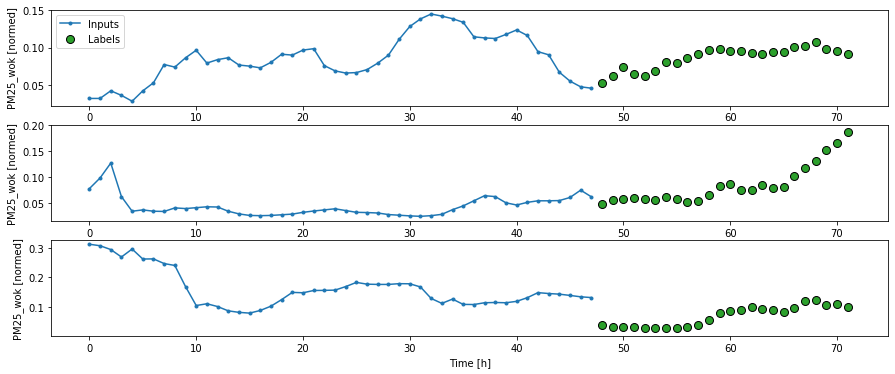

In [ ]:
#prognoza na 24 godziny, na podstawie ostatnich 48 godzin
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=48,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#przykładowego dane wejściowe (tylko PM2.5)
multi_window.plot(max_subplots=3)

In [ ]:
#pomocnicze dane do obliczania wartości metryk
for batch, (input, label) in enumerate(multi_window.train):
  if batch == 0:
    inputs_train = input
    labels_train = label
  else:
    inputs_train = tf.concat([inputs_train,input],0)
    labels_train = tf.concat([labels_train,label],0)
print(inputs_train.shape, labels_train.shape)

for batch, (input, label) in enumerate(multi_window.val):
  if batch == 0:
    inputs_val = input
    labels_val = label
  else:
    inputs_val = tf.concat([inputs_val,input],0)
    labels_val = tf.concat([labels_val,label],0)
print(inputs_val.shape, labels_val.shape)

for batch, (input, label) in enumerate(multi_window.test):
  if batch == 0:
    inputs_test = input
    labels_test = label
  else:
    inputs_test = tf.concat([inputs_test,input],0)
    labels_test = tf.concat([labels_test,label],0)
    
print(inputs_test.shape, labels_test.shape)

(None, 48, 9) (None, 24, 1)
(26260, 48, 9) (26260, 24, 1)
(None, 48, 9) (None, 24, 1)
(8690, 48, 9) (8690, 24, 1)
(None, 48, 9) (None, 24, 1)
(8713, 48, 9) (8713, 24, 1)


### model podstawowy

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
for batch, (inputs, labels) in enumerate(multi_window.val):
  if batch == 0:
    #inp = inputs
    #lab = labels

    inp2 = inputs[:,:,:1]
    inp3 = tf.reshape(inp2, [inp2.shape[0],inp2.shape[1]])
    inp4 = tf.math.reduce_mean(inp3, axis=1)
    input = tf.stack([inp4]*24, axis=1)

    label = tf.reshape(labels, [labels.shape[0],labels.shape[1]])

  else:
    inp2 = inputs[:,:,:1]
    inp3 = tf.reshape(inp2, [inp2.shape[0],inp2.shape[1]])
    inp4 = tf.math.reduce_mean(inp3, axis=1)
    inp5 = tf.stack([inp4]*24, axis=1)
    input = tf.concat([input,inp5],0)

    lab = tf.reshape(labels, [labels.shape[0],labels.shape[1]])
    label = tf.concat([label,lab],0)
    
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(label*200, input*200)
print("baseline RMSE val: ", m.result().numpy())
      
mae_train = tf.keras.metrics.MeanAbsoluteError()
mae_train.update_state(label*200, input*200)
print("baseline MAE val: ", mae_train.result().numpy() )

R2 = r2_score(label, input)
print("baseline R2: {:.1f}%".format(R2*100))

(None, 48, 1) (None, 24, 1)
baseline RMSE val:  9.8588085
baseline MAE val:  7.0505643
baseline R2: 24.1%


In [ ]:
for batch, (inputs, labels) in enumerate(multi_window.train):
  if batch == 0:
    #inp = inputs
    #lab = labels

    inp2 = inputs[:,:,:1]
    inp3 = tf.reshape(inp2, [inp2.shape[0],inp2.shape[1]])
    inp4 = tf.math.reduce_mean(inp3, axis=1)
    input = tf.stack([inp4]*24, axis=1)

    label = tf.reshape(labels, [labels.shape[0],labels.shape[1]])

  else:
    inp2 = inputs[:,:,:1]
    inp3 = tf.reshape(inp2, [inp2.shape[0],inp2.shape[1]])
    inp4 = tf.math.reduce_mean(inp3, axis=1)
    inp5 = tf.stack([inp4]*24, axis=1)
    input = tf.concat([input,inp5],0)

    lab = tf.reshape(labels, [labels.shape[0],labels.shape[1]])
    label = tf.concat([label,lab],0)
    
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(label*200, input*200)
print("baseline RMSE train: ", m.result().numpy())
      
mae_train = tf.keras.metrics.MeanAbsoluteError()
mae_train.update_state(label*200, input*200)
print("baseline MAE train: ", mae_train.result().numpy() )

R2 = r2_score(label, input)
print("baseline R2: {:.1f}%".format(R2*100))

(None, 48, 1) (None, 24, 1)
baseline RMSE train:  11.823518
baseline MAE train:  8.154959
baseline R2: 34.0%


## optuna

In [ ]:
# metryki do modeli
def metrics(model):
    results_train = model(inputs_train)
    results_val = model(inputs_val)
    results_test = model(inputs_test)
    
    rmse_train = tf.keras.metrics.RootMeanSquaredError()
    rmse_train.update_state(labels_train*200, results_train*200)
    
    rmse_val = tf.keras.metrics.RootMeanSquaredError()
    rmse_val.update_state(labels_val*200, results_val*200)
    
    rmse_test = tf.keras.metrics.RootMeanSquaredError()
    rmse_test.update_state(labels_test*200, results_test*200)
    
    
    mae_train = tf.keras.metrics.MeanAbsoluteError()
    mae_train.update_state(labels_train*200, results_train*200)
    
    mae_val = tf.keras.metrics.MeanAbsoluteError()
    mae_val.update_state(labels_val*200, results_val*200)
    
    mae_test = tf.keras.metrics.MeanAbsoluteError()
    mae_test.update_state(labels_test*200, results_test*200)
    

    results = ([rmse_train.result().numpy(), rmse_val.result().numpy(), rmse_test.result().numpy(),
              mae_train.result().numpy(), mae_val.result().numpy(), mae_test.result().numpy()])
              #R2_train, R2_val, R2_test])
  

    print("RMSE val: ", rmse_val.result().numpy(), mae_val.result().numpy())
    
    return results
    

### optuna basic-lstm

In [ ]:
model = 'basic-lstm'
fold = 'saved_model/' + model + str(BATCH_SIZE) + zakres
os.mkdir(fold)

def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.

    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    num_hidden = trial.suggest_int("n_units_l", 4, 128, log=True)
    
    model = Sequential()

    model.add(LSTM(num_hidden, return_sequences=False)),
    model.add(Dense(OUT_STEPS, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))),
    model.add(Reshape([OUT_STEPS, 1]))

    return model

def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.

    adam_lr = trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True)
    return tf.keras.optimizers.Adam(learning_rate=adam_lr)


def objective(trial):
    print(trial.number)
    
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    model.compile(loss=tf.losses.MeanSquaredError(),
          optimizer=optimizer,
          metrics=[tf.metrics.RootMeanSquaredError()])
 
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=patience, mode='min')

    history = model.fit(multi_window.train, epochs= MAX_EPOCHS,
                    validation_data=multi_window.val,
                    callbacks=[early_stopping])

    model.save('{}/model{}'.format(fold,trial.number))
        
    results = metrics(model)
        
    wyniki.append(results)

    return results[1]


if __name__ == "__main__":
    sampler = TPESampler(seed=2021)
    wyniki = []
    study = optuna.create_study(direction="minimize",sampler=sampler)
    study.optimize(objective, n_trials=25)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    print("model: ", model, "; batch size: ", BATCH_SIZE , "; data: ", zakres  )
    
    
file = open("trials_1{}_{}_{}.txt".format(model,BATCH_SIZE, zakres),"w")
file.write("study trials: \n")
file.writelines(str(study.trials))
file.write("\nBATCH_SIZE:" + str(BATCH_SIZE))
file.write("\nDATA:" + str(do_modelu))
file.write("\nbest trial: \n")
file.writelines(str(study.best_trial))
file.close()

df_wyniki=pd.DataFrame()
df_wyniki['RMSE_train'] = [item[0] for item in wyniki]
df_wyniki['RMSE_val'] = [item[1] for item in wyniki]
df_wyniki['RMSE_test'] = [item[2] for item in wyniki]
df_wyniki['MAE_train'] = [item[3] for item in wyniki]
df_wyniki['MAE_val'] = [item[4] for item in wyniki]
df_wyniki['MAE_test'] = [item[5] for item in wyniki]
df_wyniki.to_csv('wyniki_1{}_batch{}_{}.csv'.format(model, BATCH_SIZE,zakres))  

for mod in os.listdir(fold):
    if int(mod[5:]) == trial.number:
        os.rename(fold + "/" + mod, fold + "/best_" + mod)

[I 2021-06-02 22:20:44,033] A new study created in memory with name: no-name-32e14992-cbb1-4387-9124-ab8ed1061a11


0
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 30s 35ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 2/10
821/821 [==============================] - 36s 43ms/step - loss: 0.0065 - root_mean_squared_error: 0.0800 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 3/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0058 - root_mean_squared_error: 0.0758 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0614
Epoch 4/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0603
Epoch 5/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 6/10
821/821 [==============================] - 27s 33ms/step - lo

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model0\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model0\assets
[I 2021-06-02 22:25:34,621] Trial 0 finished with value: 11.831280708312988 and parameters: {'weight_decay': 1.7452110401305704e-06, 'n_units_l': 49, 'adam_lr': 3.595742861310716e-05}. Best is trial 0 with value: 11.831280708312988.


RMSE val:  11.831281 8.350324
1
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 72s 86ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0524
Epoch 2/10
821/821 [==============================] - 72s 88ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 3/10
821/821 [==============================] - 72s 88ms/step - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 4/10
821/821 [==============================] - 71s 86ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 5/10
821/821 [==============================] - 71s 86ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 6/10
821/821 [======================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model1\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model1\assets
[I 2021-06-02 22:37:53,540] Trial 1 finished with value: 9.793571472167969 and parameters: {'weight_decay': 1.5442285836679523e-08, 'n_units_l': 127, 'adam_lr': 3.255738398559085e-05}. Best is trial 1 with value: 9.793571472167969.


RMSE val:  9.793571 6.9608636
2
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 34s 39ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 2/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 3/10
821/821 [==============================] - 31s 37ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 4/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 5/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 6/10
821/821 [======================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model2\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model2\assets
[I 2021-06-02 22:42:28,226] Trial 2 finished with value: 7.631365776062012 and parameters: {'weight_decay': 1.7904068948395157e-09, 'n_units_l': 53, 'adam_lr': 0.004452890926641411}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  7.631366 5.368097
3
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 14s 16ms/step - loss: 0.0124 - root_mean_squared_error: 0.1099 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0861
Epoch 2/10
821/821 [==============================] - 13s 15ms/step - loss: 0.0111 - root_mean_squared_error: 0.1041 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0809
Epoch 3/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0100 - root_mean_squared_error: 0.0987 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0785
Epoch 4/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0096 - root_mean_squared_error: 0.0964 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0772
Epoch 5/10
821/821 [==============================] - 13s 15ms/step - loss: 0.0092 - root_mean_squared_error: 0.0943 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0758
Epoch 6/10
821/821 [=======================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model3\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model3\assets
[I 2021-06-02 22:44:47,415] Trial 3 finished with value: 14.037128448486328 and parameters: {'weight_decay': 3.0915119173834366e-05, 'n_units_l': 5, 'adam_lr': 1.7150829926878746e-05}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  14.037128 11.188131
4
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 19s 22ms/step - loss: 0.0299 - root_mean_squared_error: 0.1227 - val_loss: 0.0217 - val_root_mean_squared_error: 0.0878
Epoch 2/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0226 - root_mean_squared_error: 0.0968 - val_loss: 0.0187 - val_root_mean_squared_error: 0.0787
Epoch 3/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0200 - root_mean_squared_error: 0.0907 - val_loss: 0.0165 - val_root_mean_squared_error: 0.0742
Epoch 4/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0179 - root_mean_squared_error: 0.0871 - val_loss: 0.0146 - val_root_mean_squared_error: 0.0703
Epoch 5/10
821/821 [==============================] - 18s 21ms/step - loss: 0.0161 - root_mean_squared_error: 0.0839 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0672
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model4\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model4\assets
[I 2021-06-02 22:47:55,849] Trial 4 finished with value: 11.548832893371582 and parameters: {'weight_decay': 0.0005454713331247908, 'n_units_l': 32, 'adam_lr': 2.2208531625461777e-05}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  11.548833 8.318089
5
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 20s 23ms/step - loss: 0.0126 - root_mean_squared_error: 0.1120 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0839
Epoch 2/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 3/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 4/10
821/821 [==============================] - 19s 23ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 5/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834
Epoch 6/10
821/821 [======================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model5\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model5\assets
[I 2021-06-02 22:50:13,159] Trial 5 finished with value: 16.71694564819336 and parameters: {'weight_decay': 8.489977465125874e-07, 'n_units_l': 32, 'adam_lr': 0.07167572450040122}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  16.716946 12.582445
6
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 15s 16ms/step - loss: 0.0069 - root_mean_squared_error: 0.0827 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 2/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 3/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 4/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 5/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model6\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model6\assets
[I 2021-06-02 22:52:42,251] Trial 6 finished with value: 9.489189147949219 and parameters: {'weight_decay': 1.0474421858660304e-06, 'n_units_l': 13, 'adam_lr': 0.0006435480447505021}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  9.489189 6.686968
7
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 16s 18ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 2/10
821/821 [==============================] - 15s 18ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 3/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 4/10
821/821 [==============================] - 15s 18ms/step - loss: 0.0044 - root_mean_squared_error: 0.0667 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 5/10
821/821 [==============================] - 14s 18ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548d_error: 0.06 - ETA: 
Epoch 6/10
821/821 [==

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model7\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model7\assets
[I 2021-06-02 22:55:22,828] Trial 7 finished with value: 10.73902702331543 and parameters: {'weight_decay': 2.587925291044614e-09, 'n_units_l': 27, 'adam_lr': 6.0309245793449296e-05}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  10.739027 7.6868834
8
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 15s 17ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 2/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 3/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0044 - root_mean_squared_error: 0.0659 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0504
Epoch 4/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0452
Epoch 5/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model8\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model8\assets
[I 2021-06-02 22:57:09,834] Trial 8 finished with value: 7.856375694274902 and parameters: {'weight_decay': 1.218787844788821e-06, 'n_units_l': 19, 'adam_lr': 0.0011783046761626908}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  7.8563757 5.7705393
9
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 27s 31ms/step - loss: 0.0144 - root_mean_squared_error: 0.1121 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0792
Epoch 2/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0110 - root_mean_squared_error: 0.0965 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0757
Epoch 3/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0098 - root_mean_squared_error: 0.0905 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0701
Epoch 4/10
821/821 [==============================] - 25s 31ms/step - loss: 0.0085 - root_mean_squared_error: 0.0839 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0664
Epoch 5/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0081 - root_mean_squared_error: 0.0819 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0657ot_
Epoch 6/10
821/821 [==================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model9\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model9\assets
[I 2021-06-02 23:01:39,303] Trial 9 finished with value: 12.361910820007324 and parameters: {'weight_decay': 5.7768413117864e-05, 'n_units_l': 49, 'adam_lr': 1.8889701680886102e-05}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  12.361911 8.827272
10
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 74s 88ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 72s 87ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 71s 87ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model10\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model10\assets
[I 2021-06-02 23:05:34,798] Trial 10 finished with value: 19.589365005493164 and parameters: {'weight_decay': 3.285466869984973e-10, 'n_units_l': 118, 'adam_lr': 0.03963338456127991}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  19.589365 15.989601
11
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 15s 16ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 2/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 3/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 4/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 5/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 6/10
821/821 [====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model11\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model11\assets
[I 2021-06-02 23:07:43,365] Trial 11 finished with value: 8.015823364257812 and parameters: {'weight_decay': 2.7557184442480875e-08, 'n_units_l': 11, 'adam_lr': 0.0058597258279257025}. Best is trial 2 with value: 7.631365776062012.


RMSE val:  8.015823 6.1197295
12
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 33s 39ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 2/10
821/821 [==============================] - 32s 39ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 3/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 4/10
821/821 [==============================] - 31s 37ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 5/10
821/821 [==============================] - 31s 38ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model12\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model12\assets
[I 2021-06-02 23:13:11,379] Trial 12 finished with value: 7.614869117736816 and parameters: {'weight_decay': 3.0742851244612493e-10, 'n_units_l': 72, 'adam_lr': 0.0012448945395054317}. Best is trial 12 with value: 7.614869117736816.


RMSE val:  7.614869 5.3271265
13
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 32s 37ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 2/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 3/10
821/821 [==============================] - 30s 37ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 4/10
821/821 [==============================] - 32s 39ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 5/10
821/821 [==============================] - 30s 37ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model13\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model13\assets
[I 2021-06-02 23:17:35,707] Trial 13 finished with value: 7.581644058227539 and parameters: {'weight_decay': 1.1456671556198361e-10, 'n_units_l': 69, 'adam_lr': 0.004599415503627671}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  7.581644 5.4680223
14
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 44s 52ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 2/10
821/821 [==============================] - 42s 51ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602
Epoch 3/10
821/821 [==============================] - 43s 52ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570
Epoch 4/10
821/821 [==============================] - 42s 52ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 5/10
821/821 [==============================] - 42s 51ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model14\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model14\assets
[I 2021-06-02 23:24:56,531] Trial 14 finished with value: 7.732870578765869 and parameters: {'weight_decay': 1.406601668978721e-10, 'n_units_l': 87, 'adam_lr': 0.0002585328913564504}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  7.7328706 5.408086
15
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 34s 39ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 2/10
821/821 [==============================] - 31s 38ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 3/10
821/821 [==============================] - 32s 39ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 4/10
821/821 [==============================] - 31s 38ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model15\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model15\assets
[I 2021-06-02 23:27:17,699] Trial 15 finished with value: 8.107468605041504 and parameters: {'weight_decay': 2.444645751383393e-10, 'n_units_l': 73, 'adam_lr': 0.01004890651077326}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  8.107469 5.893777
16
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 38s 44ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 2/10
821/821 [==============================] - 36s 44ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 3/10
821/821 [==============================] - 36s 44ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 4/10
821/821 [==============================] - 36s 44ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0406
Epoch 5/10
821/821 [==============================] - 35s 43ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model16\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model16\assets
[I 2021-06-02 23:30:32,037] Trial 16 finished with value: 8.285017967224121 and parameters: {'weight_decay': 1.000016823547496e-10, 'n_units_l': 78, 'adam_lr': 0.00170888491461495}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  8.285018 6.2119164
17
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 50s 59ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 2/10
821/821 [==============================] - 48s 58ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/10
821/821 [==============================] - 49s 60ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 4/10
821/821 [==============================] - 49s 59ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 5/10
821/821 [==============================] - 48s 59ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model17\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model17\assets
[I 2021-06-02 23:36:29,763] Trial 17 finished with value: 7.899009704589844 and parameters: {'weight_decay': 5.3120597027795065e-08, 'n_units_l': 100, 'adam_lr': 0.020131749418680987}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  7.8990097 5.7649093
18
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 15s 16ms/step - loss: 0.0085 - root_mean_squared_error: 0.0925 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 2/10
821/821 [==============================] - 12s 15ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 3/10
821/821 [==============================] - 13s 15ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 4/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 5/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 6/10
821/821 [====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model18\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model18\assets
[I 2021-06-02 23:38:51,330] Trial 18 finished with value: 8.760516166687012 and parameters: {'weight_decay': 1.8003977681512796e-09, 'n_units_l': 4, 'adam_lr': 0.00023007143938356175}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  8.760516 6.5252275
19
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 33s 38ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 2/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 3/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 4/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 5/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model19\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model19\assets
[I 2021-06-02 23:42:05,663] Trial 19 finished with value: 7.842072486877441 and parameters: {'weight_decay': 7.80144259798342e-10, 'n_units_l': 54, 'adam_lr': 0.0023822923935524175}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  7.8420725 5.8782334
20
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 15s 17ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 2/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 3/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 4/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 5/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495 
Epoch 6/10
821/821 [===================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model20\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model20\assets
[I 2021-06-02 23:44:33,453] Trial 20 finished with value: 9.771097183227539 and parameters: {'weight_decay': 8.009197371203212e-09, 'n_units_l': 17, 'adam_lr': 0.000414718831267953}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  9.771097 6.9701896
21
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 29s 34ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 2/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 3/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 4/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 5/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model21\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model21\assets
[I 2021-06-02 23:47:05,902] Trial 21 finished with value: 7.78419303894043 and parameters: {'weight_decay': 1.0840745752868582e-10, 'n_units_l': 54, 'adam_lr': 0.005243597671463983}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  7.784193 5.7350774
22
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 23s 26ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 2/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 3/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 4/10
821/821 [==============================] - 22s 26ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 5/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model22\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model22\assets
[I 2021-06-02 23:49:27,904] Trial 22 finished with value: 7.677739143371582 and parameters: {'weight_decay': 1.0564166193381354e-09, 'n_units_l': 41, 'adam_lr': 0.0031392127289465114}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  7.677739 5.4911733
23
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 32s 37ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 2/10
821/821 [==============================] - 30s 37ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 3/10
821/821 [==============================] - 30s 36ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 4/10
821/821 [==============================] - 31s 38ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 5/10
821/821 [==============================] - 31s 38ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 6/10
821/821 [=====================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model23\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model23\assets
[I 2021-06-02 23:53:54,505] Trial 23 finished with value: 9.205652236938477 and parameters: {'weight_decay': 7.934837240591869e-08, 'n_units_l': 69, 'adam_lr': 0.013270042248967369}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  9.205652 6.416027
24
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 73s 87ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 2/10
821/821 [==============================] - 70s 85ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 3/10
821/821 [==============================] - 70s 86ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 4/10
821/821 [==============================] - 70s 86ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 5/10
821/821 [==============================] - 70s 86ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 6/10
821/821 [======================

INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model24\assets


INFO:tensorflow:Assets written to: saved_model/basic-lstm32meteo/model24\assets
[I 2021-06-03 00:04:48,081] Trial 24 finished with value: 8.411666870117188 and parameters: {'weight_decay': 5.822422792103022e-09, 'n_units_l': 121, 'adam_lr': 0.004298348107815367}. Best is trial 13 with value: 7.581644058227539.


RMSE val:  8.411667 5.834144
Number of finished trials:  25
Best trial:
  Value:  7.581644058227539
  Params: 
    weight_decay: 1.1456671556198361e-10
    n_units_l: 69
    adam_lr: 0.004599415503627671
model:  basic-lstm ; batch size:  32 ; data:  meteo


### optuna cnn-lstm

In [ ]:
model = 'cnn-lstm'
fold = 'saved_model/' + model + str(BATCH_SIZE) + zakres
os.mkdir(fold)

def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.

    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    num_hidden = trial.suggest_int("n_units_l", 4, 128, log=True)
    num_kernel = trial.suggest_int("n_kernel", 2, 6)
    #dropout1 = trial.suggest_float("dropout_l{}".format(1), 0.21, 1)
    dropout2 = trial.suggest_float("dropout_l{}".format(2), 0.20, 0.75)

    model = Sequential()

    model.add(Conv1D(num_features, activation='relu', kernel_size=(num_kernel),padding='same')),
    model.add(MaxPool1D(pool_size=2, strides=None, padding='valid')),
    #model.add(Dropout(dropout1)),
    model.add(LSTM(num_hidden, return_sequences=False)),
    model.add(Dropout(dropout2)),
    model.add(Dense(OUT_STEPS, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))),
    model.add(Reshape([OUT_STEPS, 1]))

    return model

def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    
    adam_lr = trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True)
    return tf.keras.optimizers.Adam(learning_rate=adam_lr)


def objective(trial):
    
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    model.compile(loss=tf.losses.MeanSquaredError(),
          optimizer=optimizer,
          metrics=[tf.metrics.RootMeanSquaredError()])
 
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=patience, mode='min')

    history = model.fit(multi_window.train, epochs=MAX_EPOCHS,
                    validation_data=multi_window.val,
                    callbacks=[early_stopping])

    model.save('{}/model{}'.format(fold,trial.number))
    results = metrics(model)
    wyniki.append(results)

    return results[1]


if __name__ == "__main__":
    sampler = TPESampler(seed=2021)
    wyniki = []
    study = optuna.create_study(direction="minimize",sampler=sampler)
    study.optimize(objective, n_trials=25) 

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    print("model: ", model, "; batch size: ", BATCH_SIZE , "; data: ", zakres  )
    
    
file = open("trials_3{}_{}_{}.txt".format(model,BATCH_SIZE, zakres),"w")
file.write("study trials: \n")
file.writelines(str(study.trials))
file.write("\nBATCH_SIZE:" + str(BATCH_SIZE))
file.write("\nDATA:" + str(do_modelu))
file.write("\nbest trial: \n")
file.writelines(str(study.best_trial))
file.close()

df_wyniki=pd.DataFrame()
df_wyniki['RMSE_train'] = [item[0] for item in wyniki]
df_wyniki['RMSE_val'] = [item[1] for item in wyniki]
df_wyniki['RMSE_test'] = [item[2] for item in wyniki]
df_wyniki['MAE_train'] = [item[3] for item in wyniki]
df_wyniki['MAE_val'] = [item[4] for item in wyniki]
df_wyniki['MAE_test'] = [item[5] for item in wyniki]
df_wyniki.to_csv('wyniki_3{}_batch{}_{}.csv'.format(model, BATCH_SIZE,zakres))  

for mod in os.listdir(fold):
    if int(mod[5:]) == trial.number:
        os.rename(fold + "/" + mod, fold + "/best_" + mod)

[I 2021-06-03 00:04:48,194] A new study created in memory with name: no-name-c9011ec1-5dfd-4676-943b-1f18d4cfc4fa


(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 19s 21ms/step - loss: 0.0185 - root_mean_squared_error: 0.1348 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 18s 21ms/step - loss: 0.0160 - root_mean_squared_error: 0.1259 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 17s 20ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 4/10
821/821 [==============================] - 17s 20ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/10
821/821 [==============================] - 17s 20ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 6/10
821/821 [==============================] - 17s 21ms/step - loss

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model0\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model0\assets
[I 2021-06-03 00:07:49,678] Trial 0 finished with value: 19.589365005493164 and parameters: {'weight_decay': 1.7452110401305704e-06, 'n_units_l': 49, 'n_kernel': 2, 'dropout_l2': 0.37197019612007787, 'adam_lr': 0.09749293061113862}. Best is trial 0 with value: 19.589365005493164.


RMSE val:  19.589365 15.989601
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 12s 13ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 2/10
821/821 [==============================] - 10s 13ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 3/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 4/10
821/821 [==============================] - 12s 15ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 5/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0030 - root_mean_squared_error: 0.0545 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 6/10
821/821 [=======================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model1\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model1\assets
[I 2021-06-03 00:09:14,816] Trial 1 finished with value: 9.663442611694336 and parameters: {'weight_decay': 7.891083300344531e-10, 'n_units_l': 7, 'n_kernel': 5, 'dropout_l2': 0.5641882828702438, 'adam_lr': 0.013716412221654385}. Best is trial 1 with value: 9.663442611694336.


RMSE val:  9.663443 7.936947
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 12s 13ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 2/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0104 - root_mean_squared_error: 0.1020 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 3/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0042 - val_root_mean_squared_error: 0.06450089 - root_mean_squared_error
Epoch 4/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 5/10
821/821 [==============================] - 10s 13ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 6/10
821/

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model2\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model2\assets
[I 2021-06-03 00:10:46,158] Trial 2 finished with value: 11.214920043945312 and parameters: {'weight_decay': 4.767171449840025e-10, 'n_units_l': 4, 'n_kernel': 6, 'dropout_l2': 0.5391065941420158, 'adam_lr': 2.2208531625461777e-05}. Best is trial 1 with value: 9.663442611694336.


RMSE val:  11.21492 8.995235
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 15s 16ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0441
Epoch 2/10
821/821 [==============================] - 13s 15ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 3/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0429
Epoch 4/10
821/821 [==============================] - 13s 16ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 5/10
821/821 [==============================] - 13s 15ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model3\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model3\assets
[I 2021-06-03 00:12:00,783] Trial 3 finished with value: 8.88007926940918 and parameters: {'weight_decay': 8.489977465125874e-07, 'n_units_l': 32, 'n_kernel': 6, 'dropout_l2': 0.5158673619500689, 'adam_lr': 0.00030524136896086646}. Best is trial 3 with value: 8.88007926940918.


RMSE val:  8.880079 6.8444524
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 12s 12ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 2/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 3/10
821/821 [==============================] - 10s 13ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 4/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 5/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model4\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model4\assets
[I 2021-06-03 00:13:10,890] Trial 4 finished with value: 8.306950569152832 and parameters: {'weight_decay': 1.4622334228624528e-07, 'n_units_l': 7, 'n_kernel': 4, 'dropout_l2': 0.30730278588816345, 'adam_lr': 0.0021618027516387694}. Best is trial 4 with value: 8.306950569152832.


RMSE val:  8.306951 5.8720374
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 13s 14ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 2/10
821/821 [==============================] - 12s 15ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 3/10
821/821 [==============================] - 11s 13ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 4/10
821/821 [==============================] - 11s 13ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 5/10
821/821 [==============================] - 12s 15ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0515
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model5\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model5\assets
[I 2021-06-03 00:15:12,880] Trial 5 finished with value: 9.811563491821289 and parameters: {'weight_decay': 2.1587100586093647e-07, 'n_units_l': 23, 'n_kernel': 6, 'dropout_l2': 0.602723764816445, 'adam_lr': 1.8889701680886102e-05}. Best is trial 4 with value: 8.306950569152832.


RMSE val:  9.8115635 7.761141
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 17s 18ms/step - loss: 0.0032 - root_mean_squared_error: 0.0556 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0428
Epoch 2/10
821/821 [==============================] - 14s 18ms/step - loss: 0.0024 - root_mean_squared_error: 0.0481 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 3/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 4/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 5/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model6\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model6\assets
[I 2021-06-03 00:16:35,036] Trial 6 finished with value: 8.162410736083984 and parameters: {'weight_decay': 5.068769539078346e-06, 'n_units_l': 36, 'n_kernel': 6, 'dropout_l2': 0.31245816689515854, 'adam_lr': 0.0029509089780652155}. Best is trial 6 with value: 8.162410736083984.


RMSE val:  8.162411 6.051006
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 13s 14ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 2/10
821/821 [==============================] - 11s 13ms/step - loss: 0.0090 - root_mean_squared_error: 0.0951 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 3/10
821/821 [==============================] - 11s 13ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 4/10
821/821 [==============================] - 10s 13ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model7\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model7\assets
[I 2021-06-03 00:17:28,439] Trial 7 finished with value: 15.529244422912598 and parameters: {'weight_decay': 2.108177064285155e-06, 'n_units_l': 10, 'n_kernel': 6, 'dropout_l2': 0.5243097451368719, 'adam_lr': 0.08454352866024936}. Best is trial 6 with value: 8.162410736083984.


RMSE val:  15.529244 12.708651
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 12s 13ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 2/10
821/821 [==============================] - 10s 13ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 3/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0711
Epoch 4/10
821/821 [==============================] - 10s 12ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model8\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model8\assets
[I 2021-06-03 00:18:18,623] Trial 8 finished with value: 13.797653198242188 and parameters: {'weight_decay': 1.2463087226516153e-07, 'n_units_l': 6, 'n_kernel': 4, 'dropout_l2': 0.4374824010887284, 'adam_lr': 0.046106085986847026}. Best is trial 6 with value: 8.162410736083984.


RMSE val:  13.797653 9.991145
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 28s 32ms/step - loss: 0.0052 - root_mean_squared_error: 0.0698 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0446
Epoch 2/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0030 - root_mean_squared_error: 0.0527 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0441
Epoch 3/10
821/821 [==============================] - 26s 32ms/step - loss: 0.0028 - root_mean_squared_error: 0.0507 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0448
Epoch 4/10
821/821 [==============================] - 26s 32ms/step - loss: 0.0026 - root_mean_squared_error: 0.0497 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0425
Epoch 5/10
821/821 [==============================] - 25s 31ms/step - loss: 0.0025 - root_mean_squared_error: 0.0488 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0429
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model9\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model9\assets
[I 2021-06-03 00:22:53,386] Trial 9 finished with value: 8.177095413208008 and parameters: {'weight_decay': 9.18564161248827e-06, 'n_units_l': 87, 'n_kernel': 4, 'dropout_l2': 0.5502564585050022, 'adam_lr': 0.00023379528483241513}. Best is trial 6 with value: 8.162410736083984.


RMSE val:  8.177095 6.111951
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 41s 48ms/step - loss: 0.0041 - root_mean_squared_error: 0.0568 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0454
Epoch 2/10
821/821 [==============================] - 41s 50ms/step - loss: 0.0030 - root_mean_squared_error: 0.0518 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0436
Epoch 3/10
821/821 [==============================] - 39s 47ms/step - loss: 0.0028 - root_mean_squared_error: 0.0498 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0416
Epoch 4/10
821/821 [==============================] - 39s 48ms/step - loss: 0.0028 - root_mean_squared_error: 0.0491 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0407
Epoch 5/10
821/821 [==============================] - 39s 48ms/step - loss: 0.0027 - root_mean_squared_error: 0.0485 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0413
Epoch 6/10
821/821 [=========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model10\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model10\assets
[I 2021-06-03 00:29:03,551] Trial 10 finished with value: 7.85351037979126 and parameters: {'weight_decay': 0.0007275784814871831, 'n_units_l': 114, 'n_kernel': 2, 'dropout_l2': 0.7216105960736392, 'adam_lr': 0.004314640094347045}. Best is trial 10 with value: 7.85351037979126.


RMSE val:  7.8535104 5.6635604
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 28s 32ms/step - loss: 0.0043 - root_mean_squared_error: 0.0569 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0412
Epoch 2/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0029 - root_mean_squared_error: 0.0504 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0406
Epoch 3/10
821/821 [==============================] - 25s 31ms/step - loss: 0.0028 - root_mean_squared_error: 0.0498 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0395
Epoch 4/10
821/821 [==============================] - 25s 31ms/step - loss: 0.0027 - root_mean_squared_error: 0.0492 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0393
Epoch 5/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0027 - root_mean_squared_error: 0.0488 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0403
Epoch 6/10
821/821 [=======================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model11\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model11\assets
[I 2021-06-03 00:31:51,235] Trial 11 finished with value: 8.585549354553223 and parameters: {'weight_decay': 0.0008545222924156731, 'n_units_l': 84, 'n_kernel': 2, 'dropout_l2': 0.7407974754285519, 'adam_lr': 0.003931444246459139}. Best is trial 10 with value: 7.85351037979126.


RMSE val:  8.585549 6.8280177
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 43s 50ms/step - loss: 0.0036 - root_mean_squared_error: 0.0544 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0471
Epoch 2/10
821/821 [==============================] - 42s 51ms/step - loss: 0.0027 - root_mean_squared_error: 0.0495 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0424
Epoch 3/10
821/821 [==============================] - 44s 54ms/step - loss: 0.0026 - root_mean_squared_error: 0.0485 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0415
Epoch 4/10
821/821 [==============================] - 42s 52ms/step - loss: 0.0026 - root_mean_squared_error: 0.0479 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0408
Epoch 5/10
821/821 [==============================] - 41s 50ms/step - loss: 0.0026 - root_mean_squared_error: 0.0479 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0438
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model12\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model12\assets
[I 2021-06-03 00:36:19,049] Trial 12 finished with value: 8.611798286437988 and parameters: {'weight_decay': 0.000901890208809806, 'n_units_l': 124, 'n_kernel': 3, 'dropout_l2': 0.24009050329777132, 'adam_lr': 0.009370147013050762}. Best is trial 10 with value: 7.85351037979126.


RMSE val:  8.611798 6.3945
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 19s 21ms/step - loss: 0.0048 - root_mean_squared_error: 0.0635 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0468
Epoch 2/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0028 - root_mean_squared_error: 0.0519 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0444
Epoch 3/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 4/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0026 - root_mean_squared_error: 0.0501 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0425
Epoch 5/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 6/10
821/821 [===========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model13\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model13\assets
[I 2021-06-03 00:38:14,386] Trial 13 finished with value: 8.85600471496582 and parameters: {'weight_decay': 6.849263090466908e-05, 'n_units_l': 50, 'n_kernel': 3, 'dropout_l2': 0.7381094587087238, 'adam_lr': 0.0007142244719590123}. Best is trial 10 with value: 7.85351037979126.


RMSE val:  8.856005 6.7270365
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 12s 13ms/step - loss: 0.0042 - root_mean_squared_error: 0.0631 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0477
Epoch 2/10
821/821 [==============================] - 11s 14ms/step - loss: 0.0037 - root_mean_squared_error: 0.0599 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0508
Epoch 3/10
821/821 [==============================] - 12s 15ms/step - loss: 0.0036 - root_mean_squared_error: 0.0592 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0480


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model14\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model14\assets
[I 2021-06-03 00:38:58,327] Trial 14 finished with value: 9.609042167663574 and parameters: {'weight_decay': 0.00013469529062082807, 'n_units_l': 17, 'n_kernel': 5, 'dropout_l2': 0.21128856980888255, 'adam_lr': 0.016826298176145556}. Best is trial 10 with value: 7.85351037979126.


RMSE val:  9.609042 6.6517334
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 45s 53ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 2/10
821/821 [==============================] - 42s 51ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 3/10
821/821 [==============================] - 46s 56ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 4/10
821/821 [==============================] - 47s 57ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 5/10
821/821 [==============================] - 41s 50ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model15\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model15\assets
[I 2021-06-03 00:43:33,394] Trial 15 finished with value: 7.884225368499756 and parameters: {'weight_decay': 1.1756831625342445e-08, 'n_units_l': 127, 'n_kernel': 3, 'dropout_l2': 0.6655988267792274, 'adam_lr': 0.002858756601074842}. Best is trial 10 with value: 7.85351037979126.


RMSE val:  7.8842254 5.5825424
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 46s 54ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 2/10
821/821 [==============================] - 40s 49ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 3/10
821/821 [==============================] - 42s 51ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 4/10
821/821 [==============================] - 41s 50ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 5/10
821/821 [==============================] - 41s 50ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 6/10
821/821 [=======================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model16\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model16\assets
[I 2021-06-03 00:50:03,994] Trial 16 finished with value: 8.760937690734863 and parameters: {'weight_decay': 4.363711250152818e-09, 'n_units_l': 124, 'n_kernel': 3, 'dropout_l2': 0.6569236412801598, 'adam_lr': 0.00012413491096183125}. Best is trial 10 with value: 7.85351037979126.


RMSE val:  8.760938 6.6011186
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 23s 26ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 2/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 3/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0023 - root_mean_squared_error: 0.0485 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 4/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 5/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model17\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model17\assets
[I 2021-06-03 00:53:19,901] Trial 17 finished with value: 7.622661113739014 and parameters: {'weight_decay': 1.2772546420587624e-08, 'n_units_l': 75, 'n_kernel': 2, 'dropout_l2': 0.673931147748008, 'adam_lr': 0.0009019104089595003}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  7.622661 5.3695574
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 28s 32ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 2/10
821/821 [==============================] - 26s 32ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 3/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 4/10
821/821 [==============================] - 25s 31ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0406
Epoch 5/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model18\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model18\assets
[I 2021-06-03 00:57:48,932] Trial 18 finished with value: 7.799448013305664 and parameters: {'weight_decay': 1.4788131401652236e-08, 'n_units_l': 80, 'n_kernel': 2, 'dropout_l2': 0.6779315165881566, 'adam_lr': 0.0007704925888398909}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  7.799448 5.625207
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 27ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 2/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 3/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 4/10
821/821 [==============================] - 23s 28ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 5/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 6/10
821/821 [=========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model19\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model19\assets
[I 2021-06-03 01:01:44,198] Trial 19 finished with value: 8.84884262084961 and parameters: {'weight_decay': 1.9498401212071602e-08, 'n_units_l': 66, 'n_kernel': 2, 'dropout_l2': 0.6580599294961716, 'adam_lr': 6.136793922259465e-05}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  8.848843 6.6567183
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 26ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 2/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 3/10
821/821 [==============================] - 22s 26ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 4/10
821/821 [==============================] - 22s 26ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 5/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model20\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model20\assets
[I 2021-06-03 01:05:32,609] Trial 20 finished with value: 8.046133041381836 and parameters: {'weight_decay': 1.392247200167151e-10, 'n_units_l': 64, 'n_kernel': 2, 'dropout_l2': 0.6131205172832512, 'adam_lr': 0.0009455425435365263}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  8.046133 6.0942593
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 31s 35ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 2/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439ared_error: 0.
Epoch 3/10
821/821 [==============================] - 29s 35ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 4/10
821/821 [==============================] - 28s 35ms/step - loss: 0.0027 - root_mean_squared_error: 0.0515 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426: 9s - loss: 0.0027 -
Epoch 5/10
821/821 [==============================] - 29s 35ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 6/1

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model21\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model21\assets
[I 2021-06-03 01:10:35,904] Trial 21 finished with value: 8.028701782226562 and parameters: {'weight_decay': 3.5568581764685484e-08, 'n_units_l': 98, 'n_kernel': 2, 'dropout_l2': 0.7492910539498078, 'adam_lr': 0.0004319779843513176}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  8.028702 5.8654943
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 20s 23ms/step - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 2/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450: 0s - loss: 0.0027 - root_mean_squared_erro
Epoch 3/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 4/10
821/821 [==============================] - 19s 23ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 5/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model22\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model22\assets
[I 2021-06-03 01:13:32,286] Trial 22 finished with value: 7.806779384613037 and parameters: {'weight_decay': 2.579317785426248e-09, 'n_units_l': 57, 'n_kernel': 2, 'dropout_l2': 0.7099697572814063, 'adam_lr': 0.0012839971218175938}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  7.8067794 5.790939
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 17s 18ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 2/10
821/821 [==============================] - 15s 19ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 3/10
821/821 [==============================] - 15s 19ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 4/10
821/821 [==============================] - 15s 18ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 5/10
821/821 [==============================] - 14s 18ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model23\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model23\assets
[I 2021-06-03 01:16:13,800] Trial 23 finished with value: 7.707639694213867 and parameters: {'weight_decay': 2.5913297115573984e-09, 'n_units_l': 41, 'n_kernel': 3, 'dropout_l2': 0.6820566302892775, 'adam_lr': 0.001275083743063374}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  7.7076397 5.641189
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 16s 17ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 2/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 3/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0031 - root_mean_squared_error: 0.0555 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 4/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 5/10
821/821 [==============================] - 14s 17ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model24\assets


INFO:tensorflow:Assets written to: saved_model/cnn-lstm32meteo/model24\assets
[I 2021-06-03 01:18:28,983] Trial 24 finished with value: 8.575430870056152 and parameters: {'weight_decay': 1.915707339420452e-09, 'n_units_l': 36, 'n_kernel': 3, 'dropout_l2': 0.6756967565335985, 'adam_lr': 0.0001367205236872213}. Best is trial 17 with value: 7.622661113739014.


RMSE val:  8.575431 6.458577
Number of finished trials:  25
Best trial:
  Value:  7.622661113739014
  Params: 
    weight_decay: 1.2772546420587624e-08
    n_units_l: 75
    n_kernel: 2
    dropout_l2: 0.673931147748008
    adam_lr: 0.0009019104089595003
model:  cnn-lstm ; batch size:  32 ; data:  meteo


### optuna autoencoder

In [ ]:
model = 'autoencoder'
fold = 'saved_model/' + model + str(BATCH_SIZE) + zakres
os.mkdir(fold)

def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.

    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    num_hidden1 = trial.suggest_int("n_units_l1", 4, 128, log=True)
    num_hidden2 = trial.suggest_int("n_units_l2", 4, 128, log=True)

    model = Sequential()

    model.add(LSTM(num_hidden1 , return_sequences=False))
    model.add(RepeatVector(24))
    model.add(LSTM(num_hidden2 , return_sequences=True))
    model.add(Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))

    return model

def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.

    adam_lr = trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True)
    return tf.keras.optimizers.Adam(learning_rate=adam_lr)


def objective(trial):
    
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    model.compile(loss=tf.losses.MeanSquaredError(),
          optimizer=optimizer,
          metrics=[tf.metrics.RootMeanSquaredError()])
 
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=patience, mode='min')

    history = model.fit(multi_window.train, epochs=MAX_EPOCHS,
                    validation_data=multi_window.val,
                    callbacks=[early_stopping])
    
    model.save('{}/model{}'.format(fold,trial.number))
    results = metrics(model)
    wyniki.append(results)

    return results[1]


if __name__ == "__main__":
    sampler = TPESampler(seed=2021)
    wyniki = []
    study = optuna.create_study(direction="minimize",sampler=sampler)
    study.optimize(objective, n_trials=25) 

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    print("model: ", model, "; batch size: ", BATCH_SIZE , "; data: ", zakres  )
    
    
file = open("trials_4{}_{}_{}.txt".format(model,BATCH_SIZE, zakres),"w")
file.write("study trials: \n")
file.writelines(str(study.trials))
file.write("\nBATCH_SIZE:" + str(BATCH_SIZE))
file.write("\nDATA:" + str(do_modelu))
file.write("\nbest trial: \n")
file.writelines(str(study.best_trial))
file.close()

df_wyniki=pd.DataFrame()
df_wyniki['RMSE_train'] = [item[0] for item in wyniki]
df_wyniki['RMSE_val'] = [item[1] for item in wyniki]
df_wyniki['RMSE_test'] = [item[2] for item in wyniki]
df_wyniki['MAE_train'] = [item[3] for item in wyniki]
df_wyniki['MAE_val'] = [item[4] for item in wyniki]
df_wyniki['MAE_test'] = [item[5] for item in wyniki]
df_wyniki.to_csv('wyniki_4{}_batch{}_{}.csv'.format(model, BATCH_SIZE,zakres))  

for mod in os.listdir(fold):
    if int(mod[5:]) == trial.number:
        os.rename(fold + "/" + mod, fold + "/best_" + mod)

[I 2021-06-03 01:18:29,064] A new study created in memory with name: no-name-f660e117-b94f-4a14-949f-0c3101442de3


(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 38s 42ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 2/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 4/10
821/821 [==============================] - 32s 39ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 5/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 6/10
821/821 [==============================] - 32s 39ms/step - loss

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model0\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model0\assets
[I 2021-06-03 01:23:42,177] Trial 0 finished with value: 8.441183090209961 and parameters: {'weight_decay': 1.7452110401305704e-06, 'n_units_l1': 49, 'n_units_l2': 6, 'adam_lr': 0.0001781116534919438}. Best is trial 0 with value: 8.441183090209961.


RMSE val:  8.441183 6.323018
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 26ms/step - loss: 0.0030 - root_mean_squared_error: 0.0530 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 2/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0430
Epoch 3/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0024 - root_mean_squared_error: 0.0482 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 4/10
821/821 [==============================] - 19s 24ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 5/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 6/10
821/821 [=========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model1\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model1\assets
[I 2021-06-03 01:26:20,516] Trial 1 finished with value: 8.090742111206055 and parameters: {'weight_decay': 0.0009565396334581948, 'n_units_l1': 6, 'n_units_l2': 7, 'adam_lr': 0.010273104718582329}. Best is trial 1 with value: 8.090742111206055.


RMSE val:  8.090742 6.0932198
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 41s 45ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 2/10
821/821 [==============================] - 37s 44ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 3/10
821/821 [==============================] - 37s 45ms/step - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 4/10
821/821 [==============================] - 37s 45ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 5/10
821/821 [==============================] - 38s 46ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model2\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model2\assets
[I 2021-06-03 01:32:52,543] Trial 2 finished with value: 8.813804626464844 and parameters: {'weight_decay': 4.316419045920484e-06, 'n_units_l1': 59, 'n_units_l2': 5, 'adam_lr': 1.7150829926878746e-05}. Best is trial 1 with value: 8.090742111206055.


RMSE val:  8.813805 6.5895457
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 29s 32ms/step - loss: 0.0032 - root_mean_squared_error: 0.0531 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0425
Epoch 2/10
821/821 [==============================] - 25s 30ms/step - loss: 0.0025 - root_mean_squared_error: 0.0482 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0420
Epoch 3/10
821/821 [==============================] - 26s 31ms/step - loss: 0.0023 - root_mean_squared_error: 0.0467 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0413
Epoch 4/10
821/821 [==============================] - 25s 30ms/step - loss: 0.0022 - root_mean_squared_error: 0.0458 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0403
Epoch 5/10
821/821 [==============================] - 25s 30ms/step - loss: 0.0021 - root_mean_squared_error: 0.0450 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0404
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model3\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model3\assets
[I 2021-06-03 01:37:19,443] Trial 3 finished with value: 7.769861221313477 and parameters: {'weight_decay': 0.0005454713331247908, 'n_units_l1': 32, 'n_units_l2': 5, 'adam_lr': 0.0017582857241627771}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  7.769861 5.6629467
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 80s 94ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 2/10
821/821 [==============================] - 78s 95ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 3/10
821/821 [==============================] - 79s 96ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 4/10
821/821 [==============================] - 83s 101ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 5/10
821/821 [==============================] - 82s 100ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 6/10
821/821 [======================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model4\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model4\assets
[I 2021-06-03 01:49:34,456] Trial 4 finished with value: 7.95517110824585 and parameters: {'weight_decay': 2.068583043230336e-06, 'n_units_l1': 113, 'n_units_l2': 28, 'adam_lr': 0.00030524136896086646}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  7.955171 5.538459
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 26ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561
Epoch 2/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 3/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494oss: 0.0033 - root_mean_square
Epoch 4/10
821/821 [==============================] - 21s 25ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 5/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 6/10
821/

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model5\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model5\assets
[I 2021-06-03 01:53:16,038] Trial 5 finished with value: 9.057729721069336 and parameters: {'weight_decay': 1.4622334228624528e-07, 'n_units_l1': 7, 'n_units_l2': 27, 'adam_lr': 6.0309245793449296e-05}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  9.05773 6.842862
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 26ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 22s 26ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 4/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 6/10
821/821 [==========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model6\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model6\assets
[I 2021-06-03 01:57:06,034] Trial 6 finished with value: 19.589365005493164 and parameters: {'weight_decay': 1.218787844788821e-06, 'n_units_l1': 19, 'n_units_l2': 23, 'adam_lr': 0.01960624999185438}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  19.589365 15.989601
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 26s 29ms/step - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 2/10
821/821 [==============================] - 24s 29ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 3/10
821/821 [==============================] - 24s 29ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 4/10
821/821 [==============================] - 23s 29ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 5/10
821/821 [==============================] - 25s 30ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 6/10
821/821 [=======================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model7\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model7\assets
[I 2021-06-03 02:01:21,202] Trial 7 finished with value: 7.865293502807617 and parameters: {'weight_decay': 1.3352887455383806e-05, 'n_units_l1': 4, 'n_units_l2': 39, 'adam_lr': 0.0037492053266503823}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  7.8652935 5.640848
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 25s 27ms/step - loss: 0.0032 - root_mean_squared_error: 0.0560 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0441
Epoch 2/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 3/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0474


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model8\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model8\assets
[I 2021-06-03 02:02:43,493] Trial 8 finished with value: 9.48320484161377 and parameters: {'weight_decay': 6.253175128033883e-05, 'n_units_l1': 7, 'n_units_l2': 32, 'adam_lr': 0.0029566781243558268}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  9.483205 7.5250406
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 60s 69ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 2/10
821/821 [==============================] - 57s 70ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 3/10
821/821 [==============================] - 56s 68ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775 0.0061 - root_mean_squared_error: 0.
Epoch 4/10
821/821 [==============================] - 56s 68ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model9\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model9\assets
[I 2021-06-03 02:06:52,803] Trial 9 finished with value: 14.697184562683105 and parameters: {'weight_decay': 1.280797128821542e-08, 'n_units_l1': 81, 'n_units_l2': 29, 'adam_lr': 0.08454352866024936}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  14.697185 12.87279
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 25s 27ms/step - loss: 0.0059 - root_mean_squared_error: 0.0738 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0443
Epoch 2/10
821/821 [==============================] - 21s 25ms/step - loss: 0.0027 - root_mean_squared_error: 0.0493 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0436
Epoch 3/10
821/821 [==============================] - 22s 26ms/step - loss: 0.0024 - root_mean_squared_error: 0.0481 - val_loss: 0.0019 - val_root_mean_squared_error: 0.04280.0025 - r
Epoch 4/10
821/821 [==============================] - 22s 26ms/step - loss: 0.0023 - root_mean_squared_error: 0.0469 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0418
Epoch 5/10
821/821 [==============================] - 23s 28ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0406
Epoch 6/10
821/821 [==============

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model10\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model10\assets
[I 2021-06-03 02:10:46,510] Trial 10 finished with value: 7.8308305740356445 and parameters: {'weight_decay': 0.0007275784814871831, 'n_units_l1': 23, 'n_units_l2': 11, 'adam_lr': 0.0007553186632344756}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  7.8308306 5.547683
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 60s 70ms/step - loss: 0.0036 - root_mean_squared_error: 0.0535 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0449
Epoch 2/10
821/821 [==============================] - 57s 69ms/step - loss: 0.0025 - root_mean_squared_error: 0.0488 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0425
Epoch 3/10
821/821 [==============================] - 57s 69ms/step - loss: 0.0023 - root_mean_squared_error: 0.0471 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0418
Epoch 4/10
821/821 [==============================] - 57s 70ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 5/10
821/821 [==============================] - 56s 68ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0393
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model11\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model11\assets
[I 2021-06-03 02:20:40,497] Trial 11 finished with value: 7.795895099639893 and parameters: {'weight_decay': 0.0009985661035231974, 'n_units_l1': 23, 'n_units_l2': 127, 'adam_lr': 0.0008893192910782873}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  7.795895 5.622107
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 58s 68ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 55s 67ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 55s 67ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 4/10
821/821 [==============================] - 56s 68ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model12\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model12\assets
[I 2021-06-03 02:24:44,664] Trial 12 finished with value: 19.58936309814453 and parameters: {'weight_decay': 1.0819992299429519e-10, 'n_units_l1': 24, 'n_units_l2': 121, 'adam_lr': 0.0022961298563996774}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  19.589363 15.989596
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 47s 54ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 44s 53ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 44s 53ms/step - loss: 0.0122 - root_mean_squared_error: 0.1102 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 4/10
821/821 [==============================] - 44s 53ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 5/10
821/821 [==============================] - 44s 53ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 6/10
821/821 [=======================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model13\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model13\assets
[I 2021-06-03 02:31:40,271] Trial 13 finished with value: 7.926206111907959 and parameters: {'weight_decay': 0.0001813842253631499, 'n_units_l1': 15, 'n_units_l2': 104, 'adam_lr': 0.0008456796508719039}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  7.926206 5.9056387
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 44s 50ms/step - loss: 0.0047 - root_mean_squared_error: 0.0581 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0445
Epoch 2/10
821/821 [==============================] - 42s 51ms/step - loss: 0.0035 - root_mean_squared_error: 0.0508 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0439
Epoch 3/10
821/821 [==============================] - 41s 50ms/step - loss: 0.0031 - root_mean_squared_error: 0.0494 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0432
Epoch 4/10
821/821 [==============================] - 42s 51ms/step - loss: 0.0028 - root_mean_squared_error: 0.0485 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0448
Epoch 5/10
821/821 [==============================] - 41s 49ms/step - loss: 0.0026 - root_mean_squared_error: 0.0477 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0429
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model14\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model14\assets
[I 2021-06-03 02:38:48,837] Trial 14 finished with value: 8.178105354309082 and parameters: {'weight_decay': 0.0008118182177676508, 'n_units_l1': 37, 'n_units_l2': 56, 'adam_lr': 0.00016968618738182913}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  8.178105 5.8737364
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 25s 28ms/step - loss: 0.0164 - root_mean_squared_error: 0.1280 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 4/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model15\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model15\assets
[I 2021-06-03 02:42:31,725] Trial 15 finished with value: 19.589365005493164 and parameters: {'weight_decay': 5.511515442733653e-05, 'n_units_l1': 14, 'n_units_l2': 11, 'adam_lr': 0.02945073344143664}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  19.589365 15.989601
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 31s 34ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 29s 36ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 33s 41ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 4/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model16\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model16\assets
[I 2021-06-03 02:44:55,588] Trial 16 finished with value: 19.589365005493164 and parameters: {'weight_decay': 8.614437698245245e-10, 'n_units_l1': 35, 'n_units_l2': 4, 'adam_lr': 0.0053386733620842215}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  19.589365 15.989601
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 26ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 2/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 3/10
821/821 [==============================] - 21s 25ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 4/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 5/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399- loss: 0.0
Epoch 6/10
821/821 [============

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model17\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model17\assets
[I 2021-06-03 02:48:32,288] Trial 17 finished with value: 7.844189167022705 and parameters: {'weight_decay': 8.335570548882958e-08, 'n_units_l1': 12, 'n_units_l2': 13, 'adam_lr': 0.0011153730093801898}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  7.844189 5.695648
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 42s 48ms/step - loss: 0.0037 - root_mean_squared_error: 0.0591 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0455
Epoch 2/10
821/821 [==============================] - 37s 45ms/step - loss: 0.0029 - root_mean_squared_error: 0.0521 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0452
Epoch 3/10
821/821 [==============================] - 37s 45ms/step - loss: 0.0028 - root_mean_squared_error: 0.0507 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0454
Epoch 4/10
821/821 [==============================] - 37s 45ms/step - loss: 0.0027 - root_mean_squared_error: 0.0497 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0435
Epoch 5/10
821/821 [==============================] - 37s 45ms/step - loss: 0.0026 - root_mean_squared_error: 0.0489 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0431
Epoch 6/10
821/821 [=========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model18\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model18\assets
[I 2021-06-03 02:53:14,851] Trial 18 finished with value: 8.641701698303223 and parameters: {'weight_decay': 0.00012131366322376337, 'n_units_l1': 31, 'n_units_l2': 77, 'adam_lr': 7.05977190165082e-05}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  8.641702 6.4515176
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 37s 42ms/step - loss: 0.0030 - root_mean_squared_error: 0.0542 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0440
Epoch 2/10
821/821 [==============================] - 35s 43ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 3/10
821/821 [==============================] - 34s 41ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 4/10
821/821 [==============================] - 34s 41ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 5/10
821/821 [==============================] - 34s 41ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model19\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model19\assets
[I 2021-06-03 02:57:33,837] Trial 19 finished with value: 8.226927757263184 and parameters: {'weight_decay': 1.5558929011207154e-05, 'n_units_l1': 49, 'n_units_l2': 16, 'adam_lr': 0.0003710724845693359}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  8.226928 5.8671207
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 31s 35ms/step - loss: 0.0069 - root_mean_squared_error: 0.0790 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0617
Epoch 2/10
821/821 [==============================] - 29s 35ms/step - loss: 0.0059 - root_mean_squared_error: 0.0725 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0590
Epoch 3/10
821/821 [==============================] - 30s 36ms/step - loss: 0.0054 - root_mean_squared_error: 0.0692 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0574
Epoch 4/10
821/821 [==============================] - 33s 41ms/step - loss: 0.0050 - root_mean_squared_error: 0.0661 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0551
Epoch 5/10
821/821 [==============================] - 29s 35ms/step - loss: 0.0047 - root_mean_squared_error: 0.0639 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0538
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model20\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model20\assets
[I 2021-06-03 03:02:41,510] Trial 20 finished with value: 9.865360260009766 and parameters: {'weight_decay': 0.0004073686831991194, 'n_units_l1': 10, 'n_units_l2': 49, 'adam_lr': 1.0822039212397708e-05}. Best is trial 3 with value: 7.769861221313477.


RMSE val:  9.86536 7.497654
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 26ms/step - loss: 0.0049 - root_mean_squared_error: 0.0545 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0432
Epoch 2/10
821/821 [==============================] - 21s 25ms/step - loss: 0.0033 - root_mean_squared_error: 0.0489 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0423
Epoch 3/10
821/821 [==============================] - 21s 25ms/step - loss: 0.0028 - root_mean_squared_error: 0.0478 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0418
Epoch 4/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0024 - root_mean_squared_error: 0.0467 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0409
Epoch 5/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0023 - root_mean_squared_error: 0.0460 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0408
Epoch 6/10
821/821 [==========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model21\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model21\assets
[I 2021-06-03 03:06:25,406] Trial 21 finished with value: 7.709071159362793 and parameters: {'weight_decay': 0.0008598650343047585, 'n_units_l1': 21, 'n_units_l2': 8, 'adam_lr': 0.000883203568490129}. Best is trial 21 with value: 7.709071159362793.


RMSE val:  7.709071 5.5599523
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 25ms/step - loss: 0.0034 - root_mean_squared_error: 0.0532 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0442
Epoch 2/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0025 - root_mean_squared_error: 0.0487 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 3/10
821/821 [==============================] - 21s 25ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0438root_mean_
Epoch 4/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 5/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0022 - root_mean_squared_error: 0.0461 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0415
Epoch 6/10
821/821 [==============

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model22\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model22\assets
[I 2021-06-03 03:09:50,541] Trial 22 finished with value: 7.925295829772949 and parameters: {'weight_decay': 0.0009993628046151754, 'n_units_l1': 19, 'n_units_l2': 7, 'adam_lr': 0.0014893689994843503}. Best is trial 21 with value: 7.709071159362793.


RMSE val:  7.925296 5.5647187
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 24s 26ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 2/10
821/821 [==============================] - 22s 26ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 3/10
821/821 [==============================] - 21s 25ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0441
Epoch 4/10
821/821 [==============================] - 21s 26ms/step - loss: 0.0024 - root_mean_squared_error: 0.0483 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 5/10
821/821 [==============================] - 22s 27ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 6/10
821/821 [========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model23\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model23\assets
[I 2021-06-03 03:13:18,984] Trial 23 finished with value: 8.583230018615723 and parameters: {'weight_decay': 2.3184100473317925e-05, 'n_units_l1': 25, 'n_units_l2': 4, 'adam_lr': 0.00044147310377562124}. Best is trial 21 with value: 7.709071159362793.


RMSE val:  8.58323 6.491327
(None, 48, 9) (None, 24, 1)
(None, 48, 9) (None, 24, 1)
Epoch 1/10
821/821 [==============================] - 29s 32ms/step - loss: 0.0161 - root_mean_squared_error: 0.1262 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0979
Epoch 2/10
821/821 [==============================] - 25s 31ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 3/10
821/821 [==============================] - 24s 29ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 4/10
821/821 [==============================] - 24s 29ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/10
821/821 [==============================] - 24s 29ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 6/10
821/821 [==========================

INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model24\assets


INFO:tensorflow:Assets written to: saved_model/autoencoder32meteo/model24\assets
[I 2021-06-03 03:16:28,141] Trial 24 finished with value: 19.589365005493164 and parameters: {'weight_decay': 0.00022143035538870287, 'n_units_l1': 30, 'n_units_l2': 9, 'adam_lr': 0.007647201241724222}. Best is trial 21 with value: 7.709071159362793.


RMSE val:  19.589365 15.989601
Number of finished trials:  25
Best trial:
  Value:  7.709071159362793
  Params: 
    weight_decay: 0.0008598650343047585
    n_units_l1: 21
    n_units_l2: 8
    adam_lr: 0.000883203568490129
model:  autoencoder ; batch size:  32 ; data:  meteo


## model machine learning

In [ ]:
from math import sqrt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

In [ ]:
y_train = train_df[do_modelu[0]]
X_train = train_df[do_modelu[1:]].values

y_val = val_df[do_modelu[0]]
X_val = val_df[do_modelu[1:]].values

y_test = test_df[do_modelu[0]]
X_test = test_df[do_modelu[1:]].values

sprawdzenie ważności cech  modelu na danych treningowych

In [ ]:
#XGBoost Regression
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 2021)
%time model_xgb.fit(X_train, y_train)

Wall time: 1.06 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=2021, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
#LightGBM 
model_lgb = lgb.LGBMRegressor(objective='regression', random_state = 2021)
%time model_lgb.fit(X_train, y_train)


Wall time: 219 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=2021, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred_xgb = model_xgb.predict(X_train)
mae_xgb = mean_absolute_error(y_train*200, y_pred_xgb*200)
rmse_xgb = mean_squared_error(y_train*200, y_pred_xgb*200, squared=False)
r2_xgb = r2_score(y_train, y_pred_xgb)
print("XGB model, train dataset")
print("mean_absolute_error: {:.4f}".format(mae_xgb))
print("root_mean_square_error: {:.4f}".format(rmse_xgb))
print("R2: {:.1f}%".format(r2_xgb*100))
print("")

y_pred_lgb = model_lgb.predict(X_train)
mae_lgb = mean_absolute_error(y_train*200, y_pred_lgb*200)
rmse_lgb = mean_squared_error(y_train*200, y_pred_lgb*200, squared=False)
r2_lgb = r2_score(y_train, y_pred_lgb)
print("LGB model, train dataset")
print("mean_absolute_error: {:.4f}".format(mae_lgb))
print("root_mean_square_error: {:.4f}".format(rmse_lgb))
print("R2: {:.1f}%".format(r2_lgb*100))

XGB model, train dataset
mean_absolute_error: 2.9962
root_mean_square_error: 4.1819
R2: 91.7%

LGB model, train dataset
mean_absolute_error: 4.0810
root_mean_square_error: 5.6480
R2: 84.9%


In [ ]:
y_pred_xgb = model_xgb.predict(X_val)
mae_xgb = mean_absolute_error(y_val*200, y_pred_xgb*200)
rmse_xgb = mean_squared_error(y_val*200, y_pred_xgb*200, squared=False)
r2_xgb = r2_score(y_val, y_pred_xgb)
print("XGB model, test dataset")
print("mean_absolute_error: {:.4f}".format(mae_xgb))
print("root_mean_square_error: {:.4f}".format(rmse_xgb))
print("R2: {:.1f}%".format(r2_xgb*100))
print("")

y_pred_lgb = model_lgb.predict(X_val)
mae_lgb = mean_absolute_error(y_val*200, y_pred_lgb*200)
rmse_lgb = mean_squared_error(y_val*200, y_pred_lgb*200, squared=False)
r2_lgb = r2_score(y_val, y_pred_lgb)
print("LGB model, test dataset")
print("mean_absolute_error: {:.4f}".format(mae_lgb))
print("root_mean_square_error: {:.4f}".format(rmse_lgb))
print("R2: {:.1f}%".format(r2_lgb*100))

XGB model, test dataset
mean_absolute_error: 6.4669
root_mean_square_error: 8.7967
R2: 39.5%

LGB model, test dataset
mean_absolute_error: 6.0723
root_mean_square_error: 8.3303
R2: 45.8%


In [ ]:
y_pred_xgb = model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test*200, y_pred_xgb*200)
rmse_xgb = mean_squared_error(y_test*200, y_pred_xgb*200, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGB model, test dataset")
print("mean_absolute_error: {:.4f}".format(mae_xgb))
print("root_mean_square_error: {:.4f}".format(rmse_xgb))
print("R2: {:.1f}%".format(r2_xgb*100))
print("")

y_pred_lgb = model_lgb.predict(X_test)
mae_lgb = mean_absolute_error(y_test*200, y_pred_lgb*200)
rmse_lgb = mean_squared_error(y_test*200, y_pred_lgb*200, squared=False)
r2_lgb = r2_score(y_test, y_pred_lgb)
print("LGB model, test dataset")
print("mean_absolute_error: {:.4f}".format(mae_lgb))
print("root_mean_square_error: {:.4f}".format(rmse_lgb))
print("R2: {:.1f}%".format(r2_lgb*100))

XGB model, test dataset
mean_absolute_error: 6.8264
root_mean_square_error: 8.8155
R2: 18.8%

LGB model, test dataset
mean_absolute_error: 6.4436
root_mean_square_error: 8.2723
R2: 28.5%


### optuna lightgbm

In [ ]:
from optuna.visualization import plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, plot_contour

In [ ]:
def objective(trial):
    #data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    #train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_val, label=y_val)

    #X_train, X_test, y_train, y_test

    param = {
        "random_state": 2021,
        "objective": "regression",
        #"metric": trial.suggest_categorical("metric", ["auc","l2", "rmse"]),
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt","dart"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'rmse')
    gbm = lgb.train(
        param, dtrain, valid_sets=[dvalid], verbose_eval=False , callbacks=[pruning_callback]
    )

    preds = gbm.predict(X_val)
    #pred_labels = np.rint(preds)
    rmse = mean_squared_error(y_val*200, preds*200, squared=False)
    return rmse


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize"
    )

    study.optimize(objective, n_trials=25)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-06-04 17:41:18,684] A new study created in memory with name: no-name-f2ae7e80-b8c4-419e-8987-7911b1f1022f
[I 2021-06-04 17:41:20,198] Trial 0 finished with value: 8.156639771966168 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.009095447979793723, 'lambda_l2': 0.9680128504897082, 'num_leaves': 244, 'feature_fraction': 0.6545828067572419, 'bagging_fraction': 0.5891359722912816, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 0 with value: 8.156639771966168.
[I 2021-06-04 17:41:20,608] Trial 1 finished with value: 8.351620130356727 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.348543533524853, 'lambda_l2': 0.01144109673783525, 'num_leaves': 94, 'feature_fraction': 0.49937093302956326, 'bagging_fraction': 0.9242827713383174, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 0 with value: 8.156639771966168.
[I 2021-06-04 17:41:20,937] Trial 2 finished with value: 8.38767313315874 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.02033

Number of finished trials: 25
Best trial:
  Value: 8.024448410267597
  Params: 
    boosting_type: dart
    lambda_l1: 0.00021103122753091276
    lambda_l2: 3.545240878139351e-06
    num_leaves: 254
    feature_fraction: 0.7651310857290821
    bagging_fraction: 0.5420075234446037
    bagging_freq: 4
    min_child_samples: 75


In [ ]:
study.best_params

{'boosting_type': 'dart',
 'lambda_l1': 0.00021103122753091276,
 'lambda_l2': 3.545240878139351e-06,
 'num_leaves': 254,
 'feature_fraction': 0.7651310857290821,
 'bagging_fraction': 0.5420075234446037,
 'bagging_freq': 4,
 'min_child_samples': 75}

In [ ]:
model_lgb2 = lgb.LGBMRegressor(objective='regression', random_state = 2021, 
                               metric = "rmse",
                               **study.best_params)
%time model_lgb2.fit(X_train, y_train)

Wall time: 1.02 s


LGBMRegressor(bagging_fraction=0.5420075234446037, bagging_freq=4,
              boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7651310857290821, importance_type='split',
              lambda_l1=0.00021103122753091276, lambda_l2=3.545240878139351e-06,
              learning_rate=0.1, max_depth=-1, metric='rmse',
              min_child_samples=75, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=254,
              objective='regression', random_state=2021, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
import joblib
# save model
joblib.dump(model_lgb2, 'model_lgb2.pkl')
# load model
#gbm_pickle = joblib.load('lgb.pkl')

['model_lgb2.pkl']

In [ ]:
y_pred_lgb = model_lgb2.predict(X_train)
mae_lgb = mean_absolute_error(y_train*200, y_pred_lgb*200)
rmse_lgb = mean_squared_error(y_train*200, y_pred_lgb*200, squared=False)
r2_lgb = r2_score(y_train, y_pred_lgb)
print("LGB model, train dataset")
print("mean_absolute_error: {:.4f}".format(mae_lgb))
print("root_mean_square_error: {:.4f}".format(rmse_lgb))
print("R2: {:.1f}%".format(r2_lgb*100))

LGB model, train dataset
mean_absolute_error: 4.2491
root_mean_square_error: 6.5874
R2: 79.5%


In [ ]:
y_pred_lgb = model_lgb2.predict(X_val)
mae_lgb = mean_absolute_error(y_val*200, y_pred_lgb*200)
rmse_lgb = mean_squared_error(y_val*200, y_pred_lgb*200, squared=False)
r2_lgb = r2_score(y_val, y_pred_lgb)
print("LGB model, val dataset")
print("mean_absolute_error: {:.4f}".format(mae_lgb))
print("root_mean_square_error: {:.4f}".format(rmse_lgb))
print("R2: {:.1f}%".format(r2_lgb*100))

LGB model, val dataset
mean_absolute_error: 5.7123
root_mean_square_error: 8.0244
R2: 49.7%


In [ ]:
y_pred_lgb = model_lgb2.predict(X_test)
mae_lgb = mean_absolute_error(y_test*200, y_pred_lgb*200)
rmse_lgb = mean_squared_error(y_test*200, y_pred_lgb*200, squared=False)
r2_lgb = r2_score(y_test, y_pred_lgb)
print("LGB model, test dataset")
print("mean_absolute_error: {:.4f}".format(mae_lgb))
print("root_mean_square_error: {:.4f}".format(rmse_lgb))
print("R2: {:.1f}%".format(r2_lgb*100))

LGB model, test dataset
mean_absolute_error: 5.7161
root_mean_square_error: 7.5260
R2: 40.8%


#korelacja

Macierz korelacji i współczynnik współliniowośći (VIF) nie wskazuje na wyraźną zależność między zmiennych objaśniającymi.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
variables_corr = ['PM25_nie', 'PM25_wok',
                  'cloudCover', 'humidity', 'precipitation',
                  'pressure', 'temperature', 'visibility', 'windBearing',
                  'windSpeed', 'month', 'year', 'hour', 'day_of_week']

In [ ]:
df[variables_corr].corr()

,PM25_nie,PM25_wok,cloudCover,humidity,precipitation,pressure,temperature,visibility,windBearing,windSpeed,month,year,hour,day_of_week
PM25_nie,1.000000,0.931368,0.022714,0.328599,-0.076447,0.132453,-0.473707,-0.374206,-0.074970,-0.330357,-0.140249,-0.068158,-0.021905,0.002993
PM25_wok,0.931368,1.000000,0.004680,0.368720,-0.075955,0.140686,-0.499049,-0.373584,-0.117085,-0.328693,-0.131571,-0.112691,-0.068532,0.014908
cloudCover,0.022714,0.004680,1.000000,0.341401,0.169501,-0.223169,-0.215189,-0.231727,0.100059,0.160916,-0.012131,0.079032,0.023352,0.010191
humidity,0.328599,0.368720,0.341401,1.000000,0.153482,-0.096045,-0.538335,-0.343141,0.074252,-0.154793,0.082041,0.013144,-0.286507,0.000205
precipitation,-0.076447,-0.075955,0.169501,0.153482,1.000000,-0.186673,0.050135,-0.177498,0.012243,0.092204,0.028849,0.017115,0.011165,-0.012234
pressure,0.132453,0.140686,-0.223169,-0.096045,-0.186673,1.000000,-0.149083,0.019263,-0.084055,-0.188370,0.077434,-0.052359,-0.011044,-0.000458
temperature,-0.473707,-0.499049,-0.215189,-0.538335,0.050135,-0.149083,1.000000,0.292747,-0.010648,-0.016272,0.243165,-0.032074,0.141182,0.006240
visibility,-0.374206,-0.373584,-0.231727,-0.343141,-0.177498,0.019263,0.292747,1.000000,-0.008898,0.076649,0.094980,0.085523,0.043429,0.000130
windBearing,-0.074970,-0.117085,0.100059,0.074252,0.012243,-0.084055,-0.010648,-0.008898,1.000000,0.115348,0.008645,0.008786,0.038618,0.008297
windSpeed,-0.330357,-0.328693,0.160916,-0.154793,0.092204,-0.188370,-0.016272,0.076649,0.115348,1.000000,-0.015942,0.090452,0.090957,-0.032376


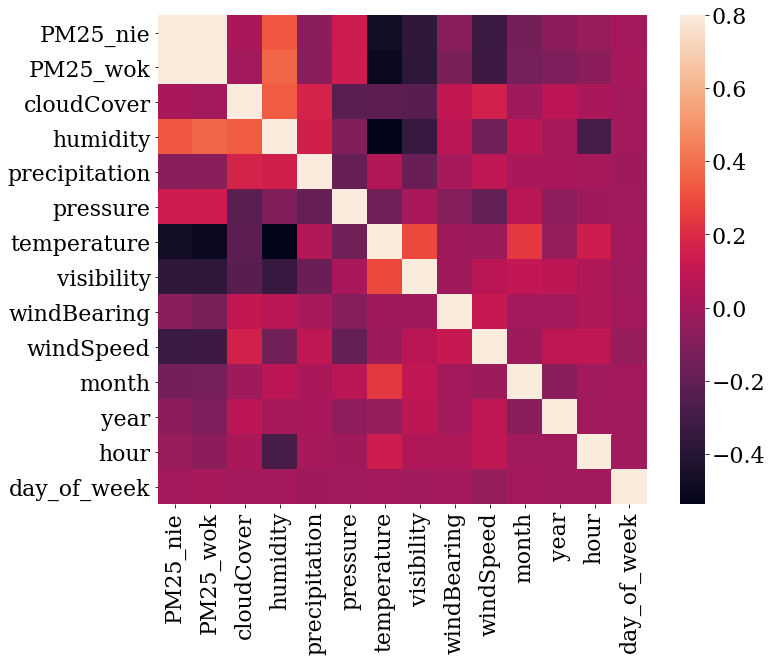

In [ ]:
plt.rcParams.update({'font.size': 22, 'font.family':'serif'})
corrmat = df[variables_corr].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
df_cor = df[variables_corr].corr()
vifs = pd.Series(np.linalg.inv(df_cor.values).diagonal(), index=df_cor.index)
vifs.sort_values(ascending=False)

PM25_wok         8.468153
PM25_nie         8.019604
temperature      2.181075
humidity         2.168023
visibility       1.339771
windSpeed        1.338513
cloudCover       1.308347
pressure         1.233496
month            1.209560
hour             1.136253
precipitation    1.133054
windBearing      1.058694
year             1.054667
day_of_week      1.003156
dtype: float64